# Aircore Corrector Modeling
---
Generating 3D field data and FieldMesh objectrs for aircore corrector magnets. There are two types of corrector coil shapes currently handled: rectangular and saddle shaped. For each type of corrector, the user can generate a FieldMesh object directly.  The main function for doing this is: `make_dipole_corrector_fieldmesh`.  To use this function the user must provide a current $I$, the definition for the uniform 3D grid of x, y, z points, specified using `xmin`, `xmax`, `nx` for each coordinate direction, and then the corrector geometry parameters specific to the type of corrector being modeled. See the two example below for a detailed description.

The default direction for correctors to kick is in the x-direction. However, correctors can be offset and rotated by including a position offset and a rotation matrix or an offset and three angles (pitch, yaw, roll).  

#### Note: care must be taken not to evaluate fields at the location of the corrector current elements, as the fields diverge there.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.constants import mu_0, pi

from pmd_beamphysics.fields.corrector_modeling import make_dipole_corrector_fieldmesh 

## SADDLE COIL CORRECTOR

The saddle coil corrector is parameterized by: 

1. $R$ [m], radius in x-y plane
2. $L$ [m], length in the z-direction,
3. $\theta$ [rad],  openining angle of the saddle arc, specifying the arc length of the curved sections: $s=R\theta$
4. npts [int], number of straight line segments used to approximate the saddle arcs.

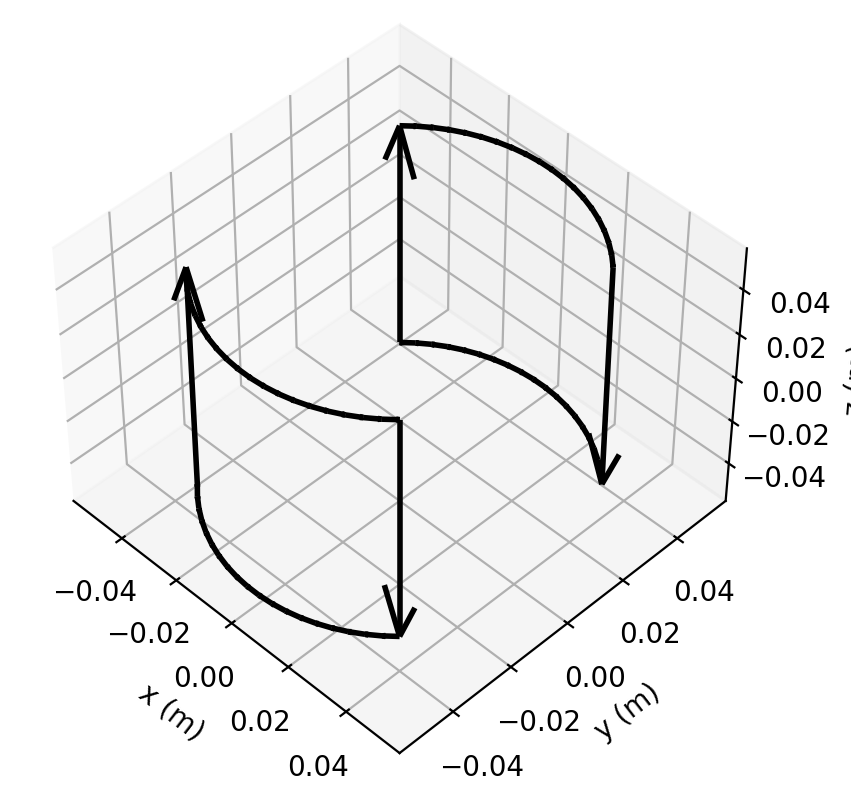

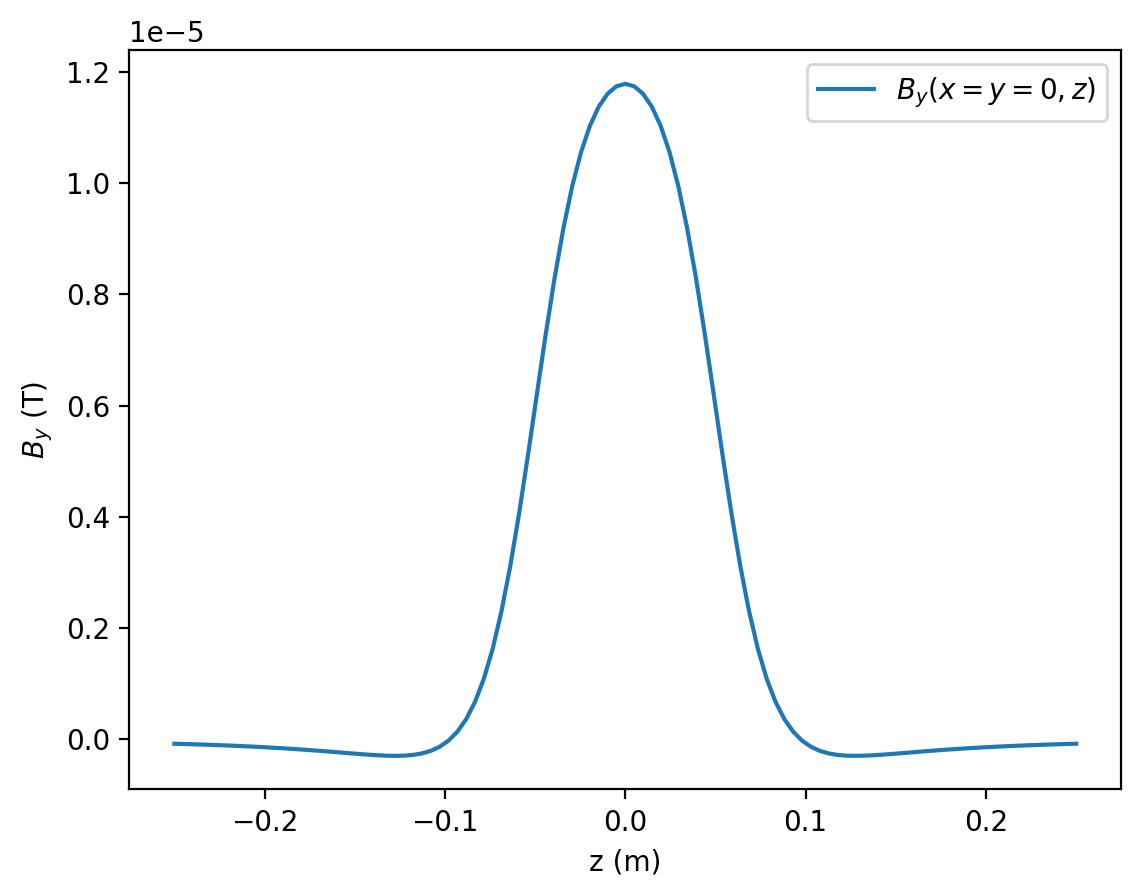

In [2]:
R = 2*2.54e-2      # 2" radius [m]
L = 0.1            # Length along z [m]
theta = np.pi/2    # Opening angle [rad]
current=1          # Current [Amp]

FM = make_dipole_corrector_fieldmesh(current=current,
                                     xmin=-R, xmax=R, nx=101,
                                     ymin=-R, ymax=R, ny=102,
                                     zmin=-5*L/2, zmax=5*L/2, nz=103,
                                     mode='saddle',
                                     R=R, L=L, theta=theta, npts=20, 
                                     plot_wire=True)
FM.plot_onaxis('By')

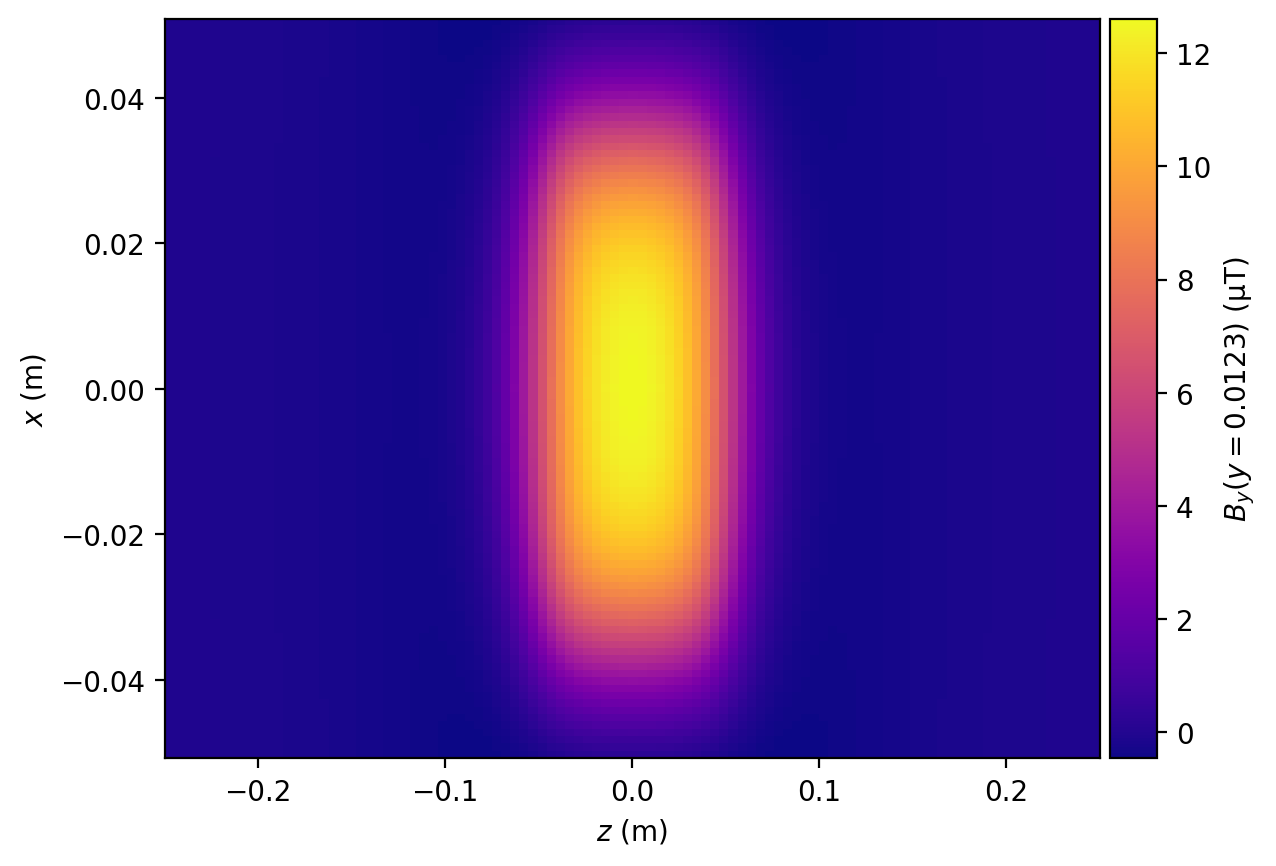

In [3]:
FM.plot('By', y=0.0123)


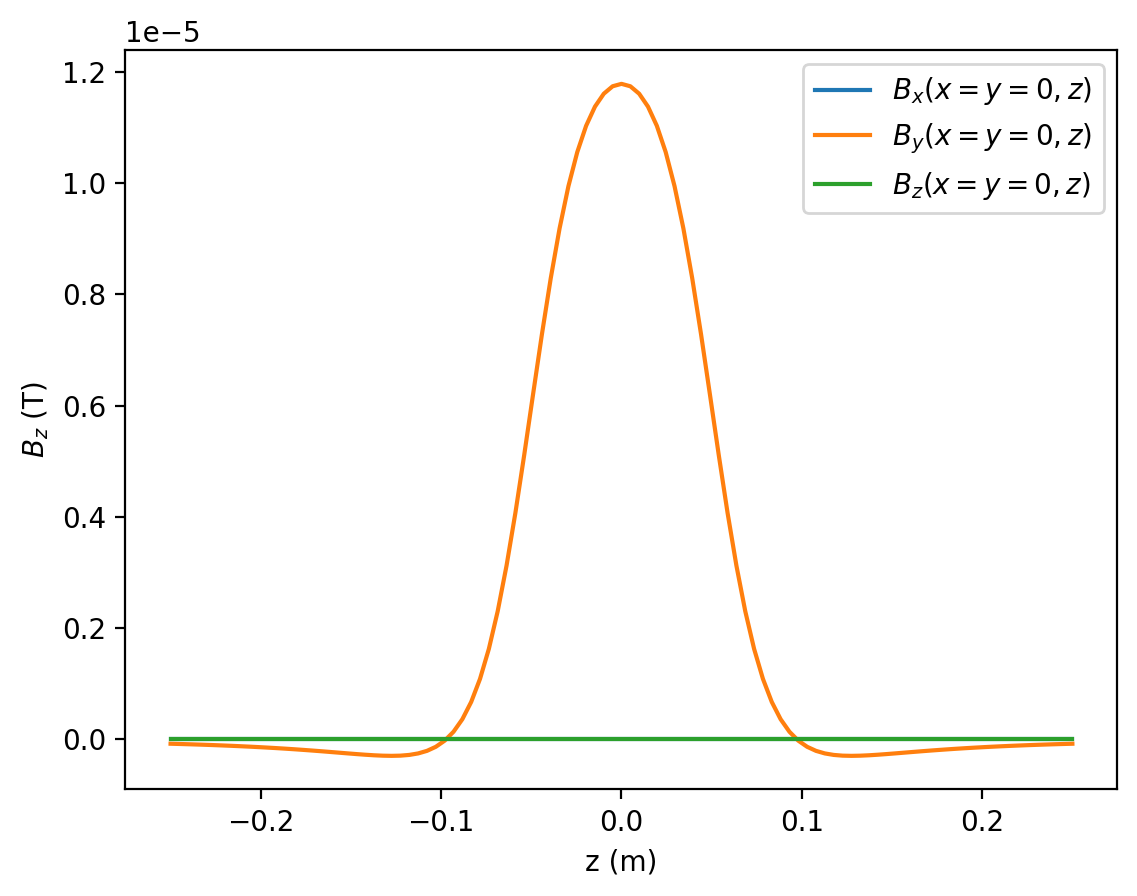

In [4]:
FM.plot_onaxis(['Bx', 'By', 'Bz'])

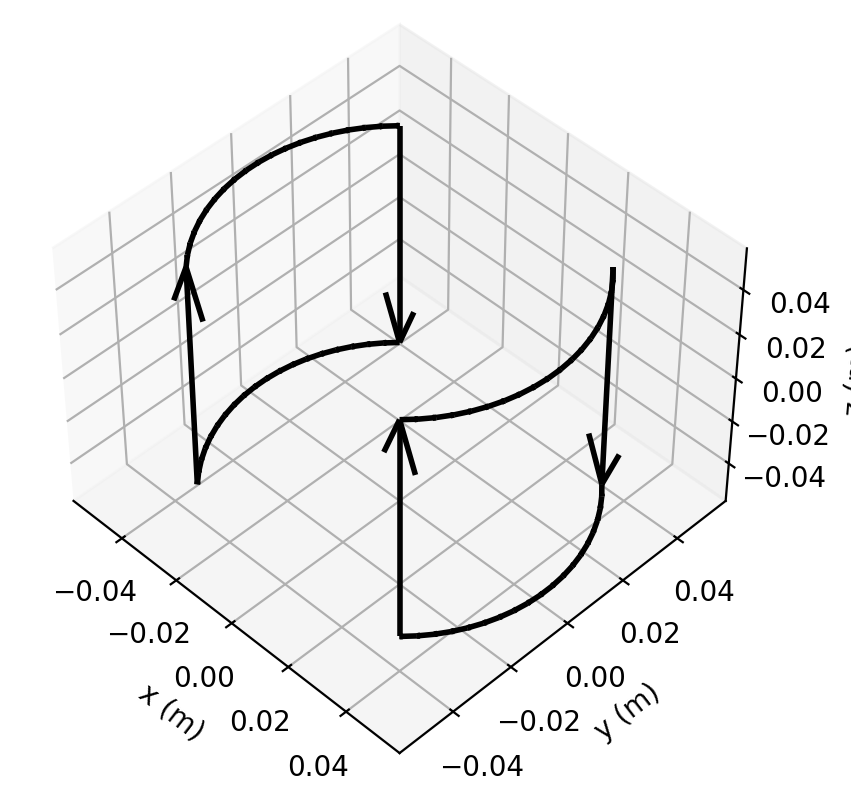

In [5]:
FM = make_dipole_corrector_fieldmesh(current=current,
                                     xmin=-R, xmax=R, nx=101,
                                     ymin=-R, ymax=R, ny=101,
                                     zmin=-5*L/2, zmax=5*L/2, nz=101,
                                     mode='saddle',
                                     R=R, L=L, theta=theta, npts=20, 
                                     plot_wire=True,
                                     tilt=np.pi/2)

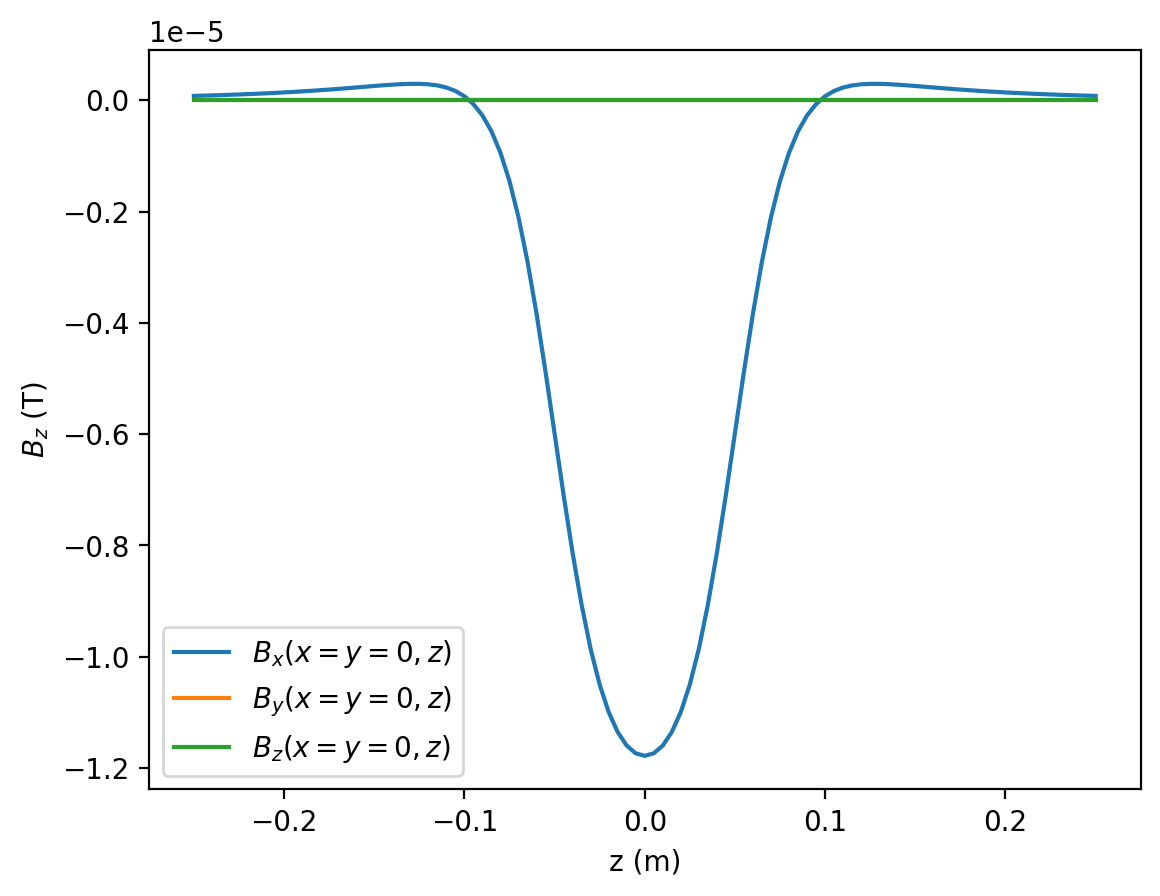

In [6]:
FM.plot_onaxis(['Bx', 'By', 'Bz'])

## RECTANGULAR COIL CORRECTOR

The rectangular coil corrector is defined by two rectangular coils separated in the x-direction and is parameterized by: 

1. $a$ [m], horizontal separation of to coils 
2. $h$ [m], height of coils (in y-direction)
3. $b$ [m], length in coils (in z-direction),

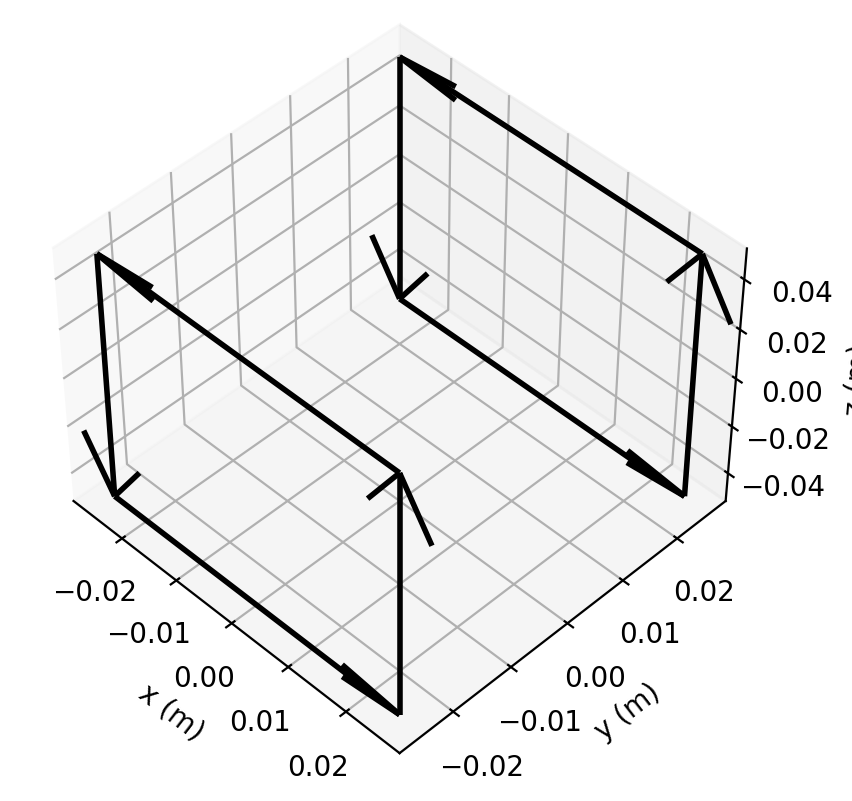

In [7]:
a = 2*2.54e-2 # 2" pipe [m]
h = a         # Square corrector
b  = 0.1      # Length [m]
L = 0.1            # Length along z [m]
current=1

FM = make_dipole_corrector_fieldmesh(current=current,
                                     xmin=-0.99*a, xmax=0.99*a, nx=101, # Mind the wires
                                     ymin=-0.99*h, ymax=0.99*h, ny=101, # Mind the wires
                                     zmin=-5*L/2,  zmax=+5*L/2, nz=101,
                                     mode='rectangular',
                                     a=a, b=b, h=h, plot_wire=True)


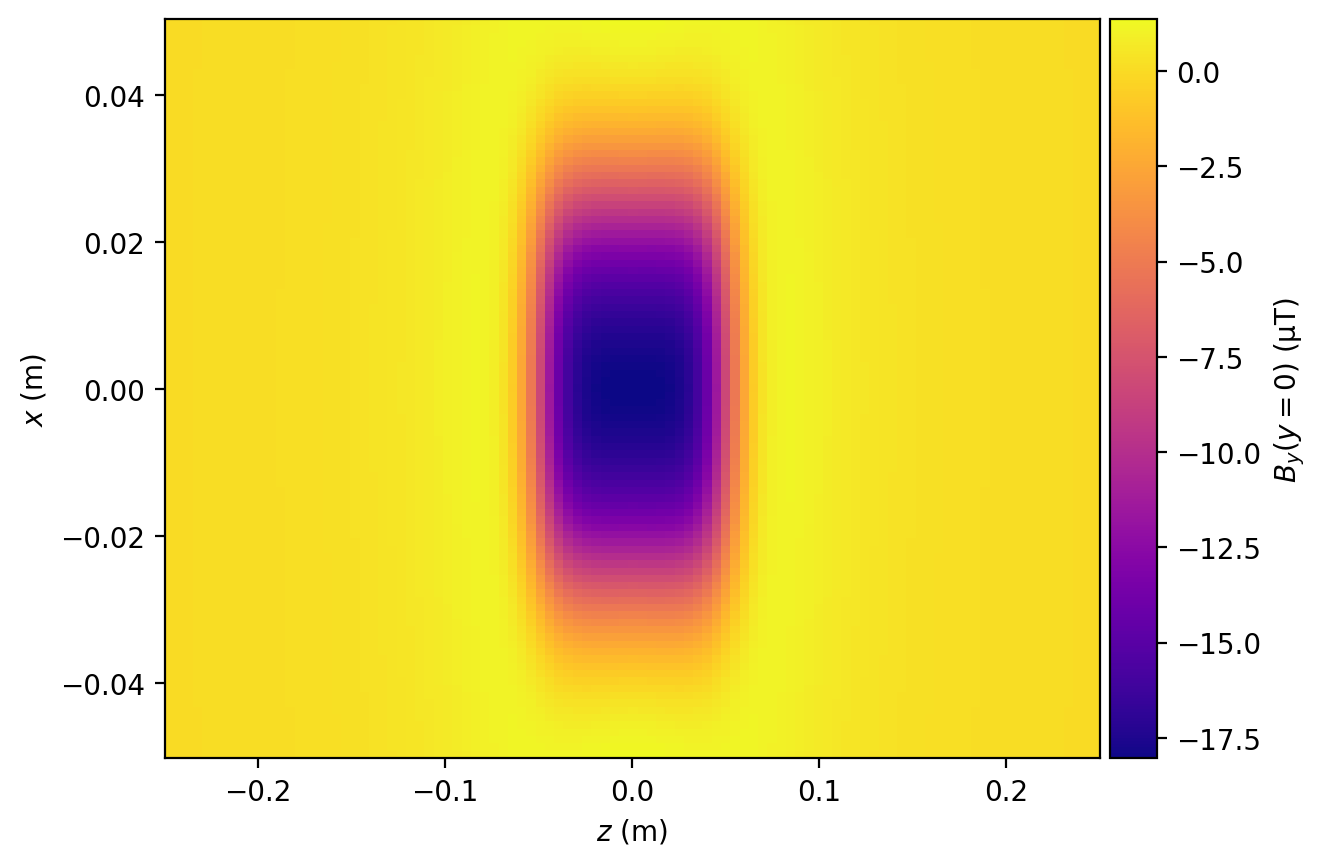

In [8]:
FM.plot(component='By', y=0)

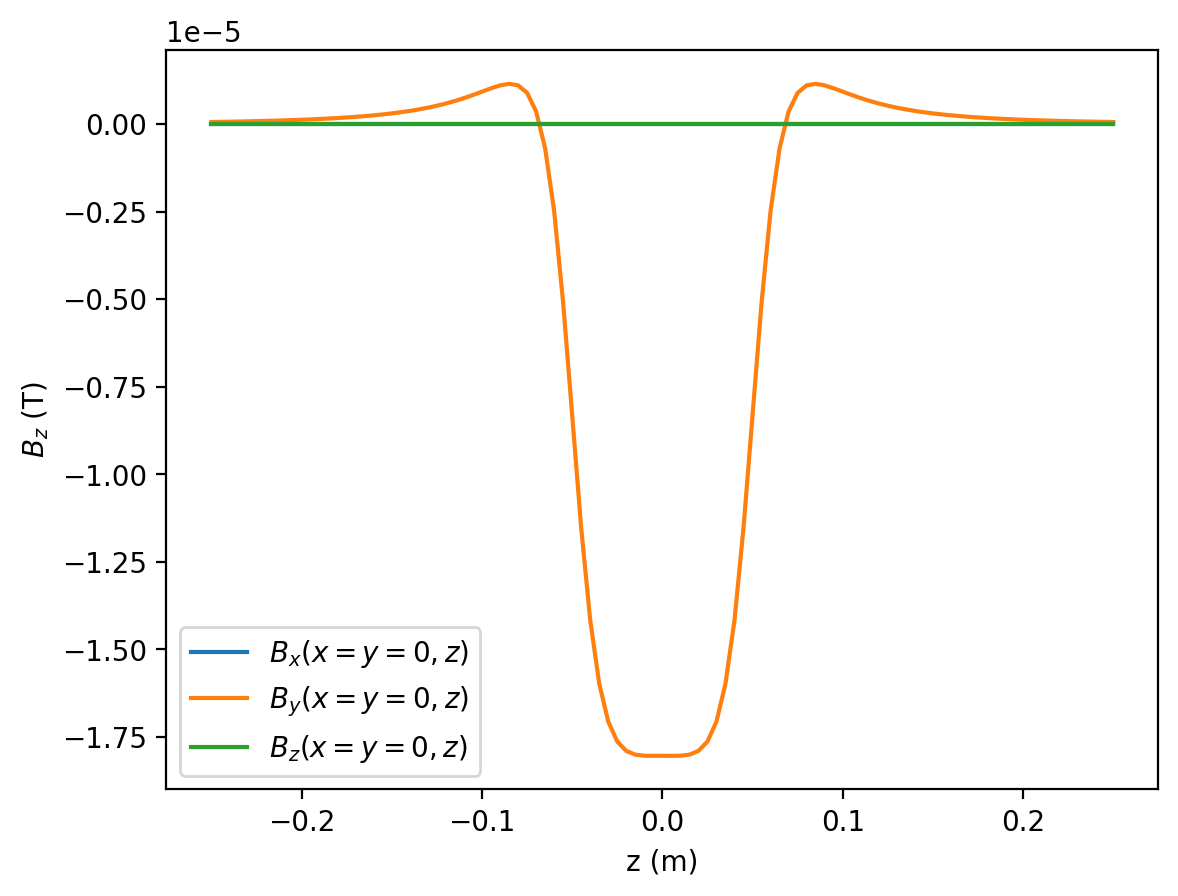

In [9]:
FM.plot_onaxis(['Bx', 'By', 'Bz'])

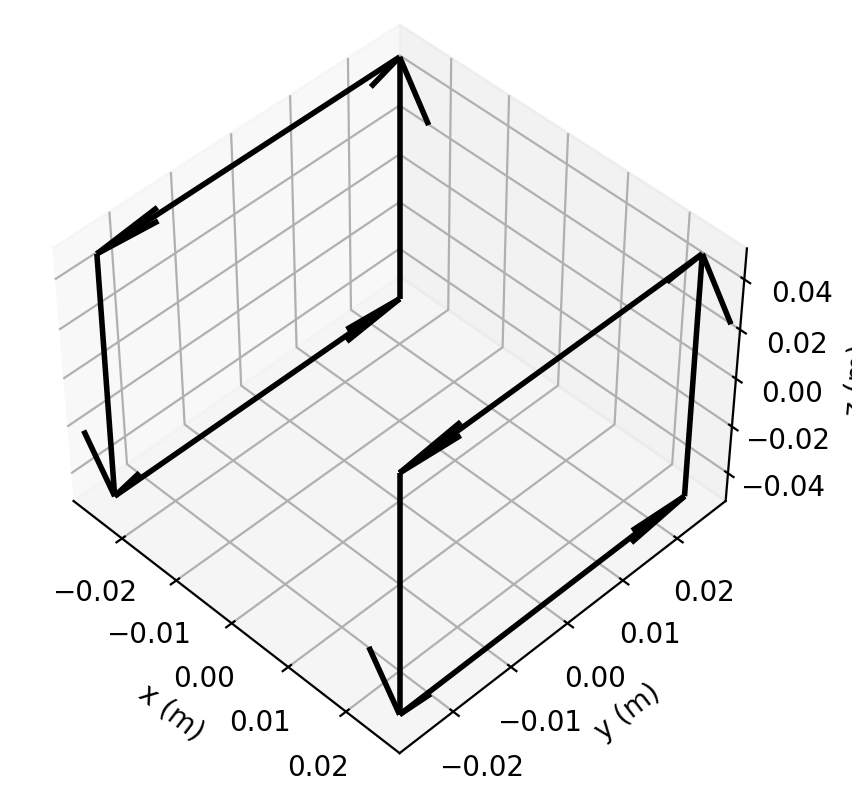

In [10]:
FM = make_dipole_corrector_fieldmesh(current=current,
                                     xmin=-0.99*h, xmax=0.99*h, nx=101, # Mind the wires
                                     ymin=-0.99*a, ymax=0.99*a, ny=101, # Mind the wires
                                     zmin=-5*L/2,  zmax=+5*L/2, nz=101,
                                     mode='rectangular',
                                     a=a, b=b, h=h, plot_wire=True, 
                                     tilt=np.pi/2)

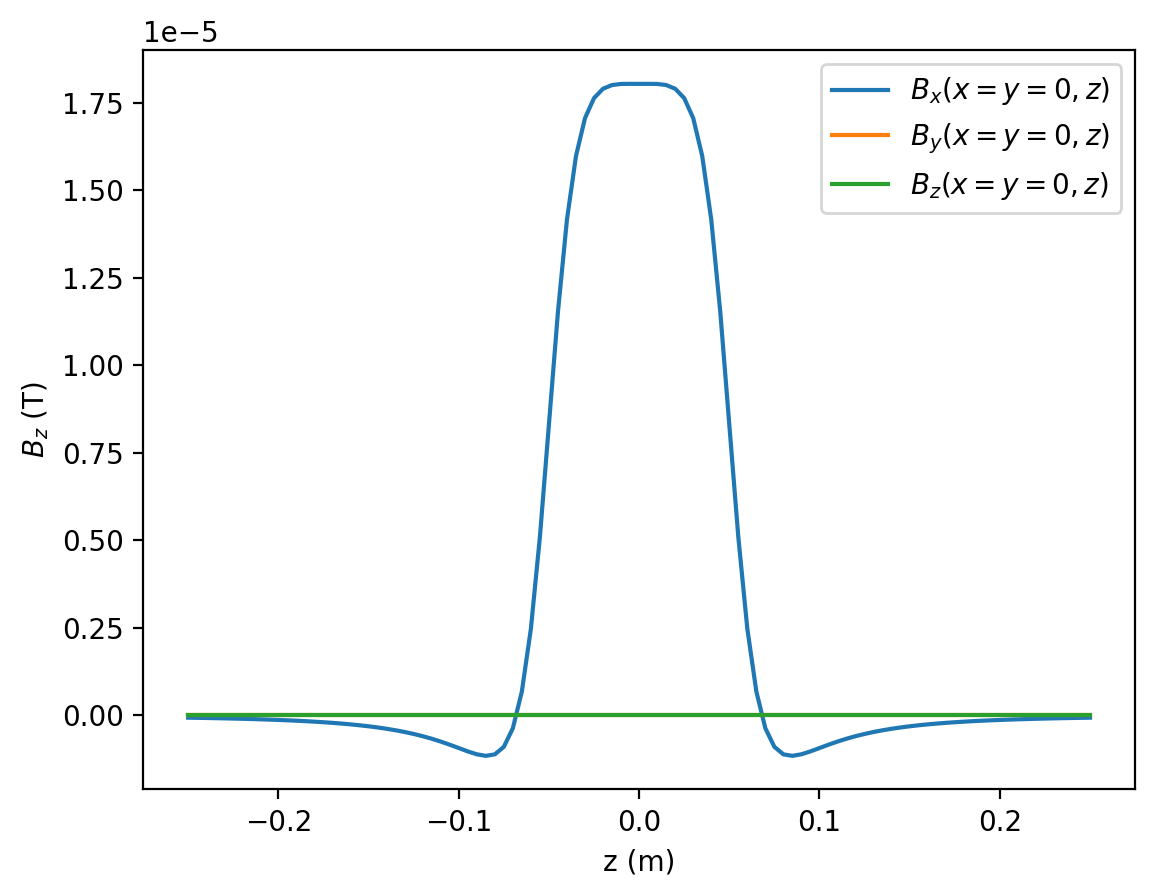

In [11]:
FM.plot_onaxis(['Bx', 'By', 'Bz'])

## THIN STRAIGHT WIRE

Users can generate a FieldMesh object storing fields from a thin straight wire segment by passing in the two points $\textbf{r}_1$ and $\textbf{r}_2$ defining the current element $Id\textbf{l} = Idl \frac{\textbf{r}_2 - \textbf{r}_1}{|\textbf{r}_2 - \textbf{r}_1|}$.

In [12]:
from pmd_beamphysics.fields.corrector_modeling import make_thin_straight_wire_fieldmesh

r1 = np.array([-0.75, 0, 0])  # Start point of the wire
r2 = np.array([+0.75, 0, 0])  # End point of the wire

FM = make_thin_straight_wire_fieldmesh(r1, r2, 
                                       xmin=-1,    xmax=1,    nx=250,
                                       ymin=-0.25, ymax=0.25, ny=300,
                                       zmin=-1,    zmax=1,    nz=350)

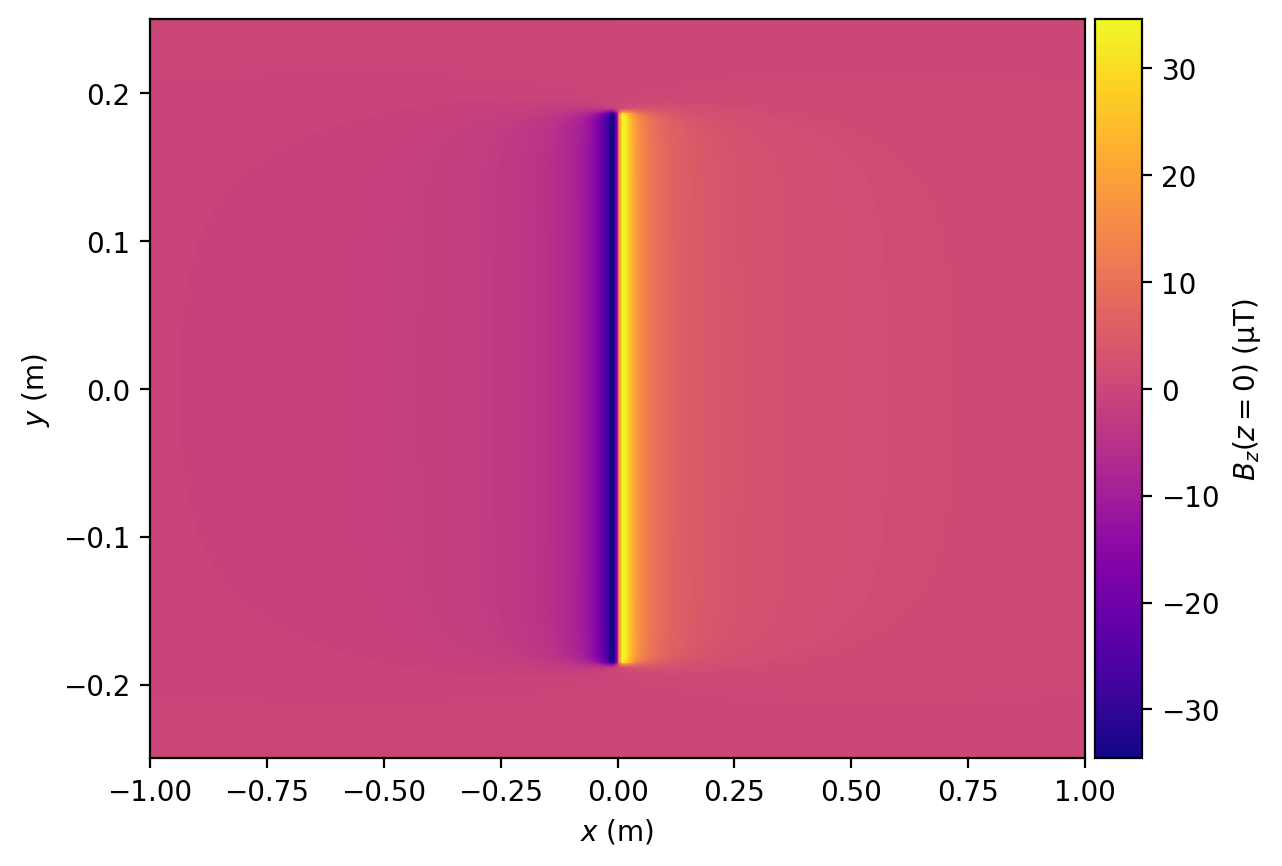

In [13]:
FM.plot(component='Bz', z=0)

# Helper Functions
---
All of the corrector models here make use of one main helper function which computes the fields from a thin, straight current element exactly using the analytic solution from the Biot-Savart law:

$\textbf{B} = \frac{\mu_0I}{4\pi R}\left(\frac{x_2}{\sqrt{x_2^2+R^2}}-\frac{x_1}{\sqrt{x_1^2 + R^2}}\right)\hat\phi$

Here $R$ is the minimal distance from a line in 3d space which containts the current segment and the observation point $\textbf{r}$, and $x_1$, and $x_2$.  The observation point and the current segment form a plane, in which one can specifcy a coordinate system so that the x-coordinate runs along the current segment and x=0 specifies the intersection point of the line used to define $R$.  In this coordinate system $x_1$ and $x_2$ are the start and end points of the wire.  $\hat\phi$ is the unit vector normal to the plane. 

Below give examples how how to use this function as well as other functions used to build up the corrector models.

In [14]:
from pmd_beamphysics.fields.corrector_modeling import bfield_from_thin_straight_wire
from pmd_beamphysics.fields.corrector_modeling import bfield_from_thin_rectangular_coil
from pmd_beamphysics.fields.corrector_modeling import bfield_from_thin_rectangular_corrector
from pmd_beamphysics.fields.corrector_modeling import bfield_from_thin_wire_arc
from pmd_beamphysics.fields.corrector_modeling import bfield_from_thin_saddle_coil
from pmd_beamphysics.fields.corrector_modeling import bfield_from_thin_saddle_corrector

(-1.0, 1.0)

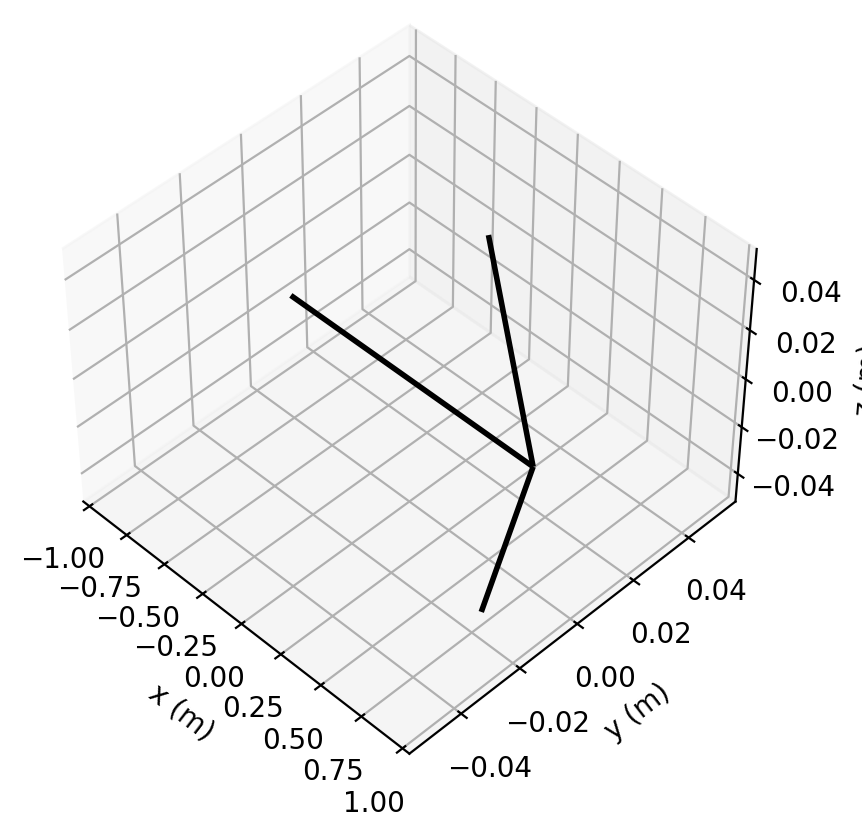

In [15]:
# Example usage with a grid of points
current = 1
x = np.linspace(-1, 1, 250)
y = np.linspace(-0.25, 0.25, 300)
z = np.linspace(-1, 1, 150)

# Create meshgrid
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Define wire endpoints and current
p1 = np.array([-0.75, 0, 0])  # Start point of the wire
p2 = np.array([+0.75, 0, 0])  # End point of the wire



# Compute the magnetic field over the grid
Bx, By, Bz = bfield_from_thin_straight_wire(X, Y, Z, p1, p2, current, plot_wire=True)
ax = plt.gca()
ax.set_xlim([-1, 1])

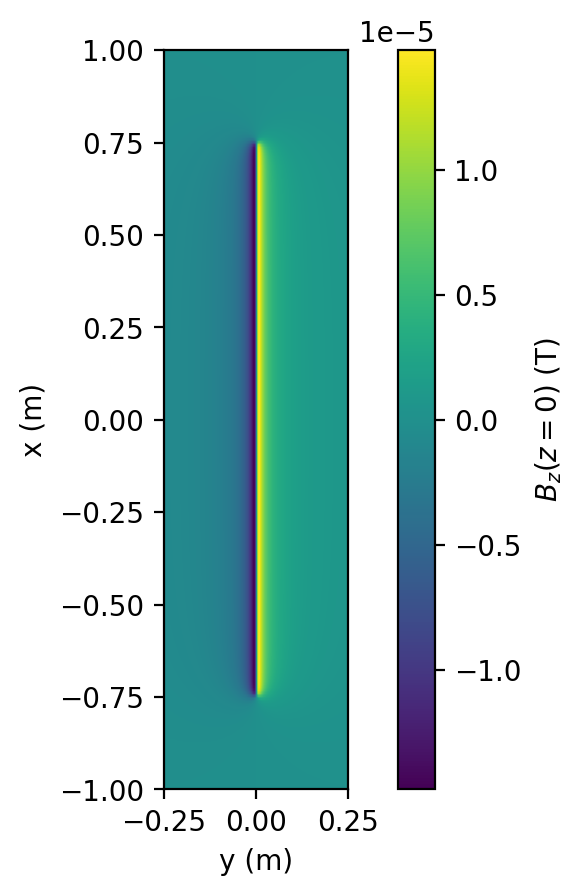

In [16]:
plt.imshow(Bz[:,:,75], extent = [y[0], y[-1], x[0], x[-1]], origin='lower')
plt.xlabel('y (m)')
plt.ylabel('x (m)')

plt.colorbar(label=r'$B_z(z=0)$ (T)')

### Tests

1. In the limit that the length of the wire $L\rightarrow\infty$, then $B_z(x=0, y=R, z=0)\rightarrow \frac{\mu_0 I}{2\pi R}$

In [17]:
current=1
R = 1
L = 1000
p1 = [-L/2, 0, 0]
p2 = [+L/2, 0, 0]

P =  [0, R, 0]

x = np.linspace(-L/2, L/2, 11)
y = np.linspace(0.1, R, 10)     # Makes sure not to evluate on the wire
z = np.linspace(0, R, 10)

X, Y, Z = np.meshgrid(x, y, z)

_, _, Bz = bfield_from_thin_straight_wire(X, Y, Z, p1, p2, current)

B0 = Bz[(X==0) & (Y==R) & (Z==0)]

assert np.isclose(mu_0*current/2/pi/R, B0), "Wire expression does not reproduce infinite limit"

## Fields from a rectangular coil in the X-Z plane

Here we create basically half of a rectangular corrector.

In [ ]:
a = 2*2.54e-2 # Assume 2" pipe
h = a
b  = 0.1

x = np.linspace(-2*a, 2*a, 200)
y = np.linspace(-2*a, 2*a, 201)
z = np.linspace(-3*b, 3*b, 200)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

BxCoil, ByCoil, BzCoil = bfield_from_thin_rectangular_coil(X, Y, Z, a, b, h, current, plot_wire=True)
#ax = plt.gca()
#ax.set_xlim([-2*a, 2*a])
#ax.set_ylim([-2*b, 2*b])

In [ ]:
indx = np.argmin(np.abs(x))
indy = np.argmin(np.abs(y))

plt.imshow(ByCoil[:,indy,:], extent = [z[0], z[-1], x[0], x[-1]], origin='lower')
plt.xlabel('z (m)')
plt.ylabel('x (m)')

plt.colorbar(label=r'$B_y(x=y=0,z)$ (T)')

In [ ]:
plt.plot(z, BxCoil[indx, indy,:])
plt.plot(z, ByCoil[indx, indy,:])
plt.plot(z, BzCoil[indx, indy,:])

plt.xlabel('z (m)')
plt.ylabel(r'$B$ (T)')
plt.legend([r'$B_x(x=y=0,z)$', r'$B_y(x=y=0,z)$', r'$B_z(x=y=0,z)$'])


## Field from rectangular corrector (two coils)

In [ ]:
a = 2*2.54e-2 # Assume 2" pipe
h = a
b  = 0.1

BxCor, ByCor, BzCor = bfield_from_thin_rectangular_corrector(X, Y, Z, a, b, h, current, plot_wire=True)

In [ ]:
indx = np.argmin(np.abs(x))
indy = np.argmin(np.abs(y))

plt.imshow(ByCor[:,indy,:], extent = [z[0], z[-1], x[0], x[-1]], origin='lower')
plt.xlabel('z (m)')
plt.ylabel('x (m)')

plt.colorbar(label=r'$B_y(x=y=0,z)$ (T)')

In [ ]:
plt.plot(z, BxCor[indx, indy,:])
plt.plot(z, ByCor[indx, indy,:])
plt.plot(z, BzCor[indx, indy,:])

plt.xlabel('z (m)')
plt.ylabel(r'$B$ (T)')
plt.legend([r'$B_x(x=y=0,z)$', r'$B_y(x=y=0,z)$', r'$B_z(x=y=0,z)$'])


## Field from segmented arc

In [ ]:
h = 0
R = 1
theta=np.pi

x = np.linspace(-1, 1, 200)
y = np.linspace(-0.2, 1, 200)
z = np.linspace(-1, 1, 150)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

Bx, By, Bz = bfield_from_thin_wire_arc(X, Y, Z, 0, R, theta, npts=15, current=1, plot_wire=True)



In [ ]:
indz = np.argmin(np.abs(z))

plt.imshow(Bz[:,:,indz], extent = [y[0], y[-1], x[0], x[-1]], origin='lower')
plt.xlabel('y (m)')
plt.ylabel('x (m)')

plt.colorbar(label=r'$B_z(z=0)$ (T)')

In [ ]:
h = 0
R = 1
L = 2
theta=np.pi

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
z = np.linspace(-3, 3, 100)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

Bx, By, Bz = bfield_from_thin_saddle_coil(X, Y, Z, L, R, theta, npts=5, current=1, plot_wire=True)



In [ ]:
indz = np.argmin(np.abs(z))

plt.imshow(Bz[:,:,indz], extent = [y[0], y[-1], x[0], x[-1]], origin='lower')
plt.xlabel('y (m)')
plt.ylabel('x (m)')

plt.colorbar(label=r'$B_z(z=0)$ (T)')



In [ ]:
R = 2*2.54e-2
L = 0.1
theta = 2*np.pi/3

x = np.linspace(-R, R, 101)
y = np.linspace(-R, R, 101)
z = np.linspace(-5*L/2, 5*L/2, 301)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

BxS, ByS, BzS = bfield_from_thin_saddle_corrector(X, Y, Z, L, R, theta, npts=20, current=1, plot_wire=True)

In [ ]:
indx = np.argmin(np.abs(x))
indy = np.argmin(np.abs(y))

plt.imshow(ByS[:,indy,:], extent = [z[0], z[-1], x[0], x[-1]], origin='lower')
plt.xlabel('z (m)')
plt.ylabel('x (m)')

plt.colorbar(label=r'$B_y(x=y=0,z)$ (T)')

In [ ]:
plt.plot(z, BxS[indx, indy,:])
plt.plot(z, ByS[indx, indy,:])
plt.plot(z, BzS[indx, indy,:])

plt.xlabel('z (m)')
plt.ylabel(r'$B$ (T)')
plt.legend([r'$B_x(x=y=0,z)$', r'$B_y(x=y=0,z)$', r'$B_z(x=y=0,z)$'])

In [ ]:
np.eye(3)